In [1]:
# Install Ultralytics
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 22.5 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import os
import shutil
import yaml
import glob
from xml.dom import minidom
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# ==========================
# 📌 Step 1: YAML File Setup
# ==========================
yaml_path = "/kaggle/working/dataset.yaml"

data = {
    "train": "/kaggle/working/images",
    "val": "/kaggle/working/images",
    "test": "/kaggle/working/images",
    "nc": 2,
    "names": ["Without Helmet", "With Helmet"]
}

# Write dataset.yaml
with open(yaml_path, "w") as f:
    yaml.dump(data, f, default_flow_style=False)

print("✅ dataset.yaml created successfully!")

✅ dataset.yaml created successfully!


In [4]:
# ==========================
# 📌 Step 2: Prepare Directory Structure
# ==========================
label_dir = "/kaggle/working/labels"

# Remove old labels folder and create a new one
if os.path.exists(label_dir):
    shutil.rmtree(label_dir)
os.makedirs(label_dir, exist_ok=True)
print(f"✅ Created clean label directory: {label_dir}")

# Copy images from dataset
!cp -r /kaggle/input/helmet-detection/images/ /kaggle/working/

✅ Created clean label directory: /kaggle/working/labels


In [5]:
# ==========================
# 📌 Step 3: Convert XML Annotations to YOLO Format
# ==========================
lut = {"Without Helmet": 0, "With Helmet": 1}  # Class lookup table

def get_text(tag, parent):
    """Helper function to extract text from an XML tag."""
    return parent.getElementsByTagName(tag)[0].firstChild.data

def convert_coordinates(size, box):
    """Convert Pascal VOC bounding box format to YOLO format."""
    dw, dh = 1.0 / size[0], 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0 * dw
    y = (box[2] + box[3]) / 2.0 * dh
    w = (box[1] - box[0]) * dw
    h = (box[3] - box[2]) * dh
    return x, y, w, h

def convert_xml2yolo(lut, input_folder, output_folder):
    """Converts all XML annotations in input_folder to YOLO format."""
    for fname in glob.glob(os.path.join(input_folder, "*.xml")):
        xmldoc = minidom.parse(fname)
        size = xmldoc.getElementsByTagName("size")[0]
        
        width, height = int(get_text("width", size)), int(get_text("height", size))
        fname_out = os.path.join(output_folder, os.path.basename(fname).replace(".xml", ".txt"))

        with open(fname_out, "w") as f:
            for item in xmldoc.getElementsByTagName("object"):
                class_name = get_text("name", item)
                if class_name not in lut:
                    print(f"⚠️ Warning: Unknown label '{class_name}' in {fname}. Skipping.")
                    continue

                # Bounding box extraction
                bbox = item.getElementsByTagName("bndbox")[0]
                xmin, xmax = float(get_text("xmin", bbox)), float(get_text("xmax", bbox))
                ymin, ymax = float(get_text("ymin", bbox)), float(get_text("ymax", bbox))
                
                bb = convert_coordinates((width, height), (xmin, xmax, ymin, ymax))
                f.write(f"{lut[class_name]} " + " ".join(f"{x:.6f}" for x in bb) + "\n")

        print(f"✅ Converted: {fname_out}")

# Convert XML files to YOLO format
convert_xml2yolo(lut, "/kaggle/input/helmet-detection/annotations", "/kaggle/working/labels")

✅ Converted: /kaggle/working/labels/BikesHelmets338.txt
✅ Converted: /kaggle/working/labels/BikesHelmets680.txt
✅ Converted: /kaggle/working/labels/BikesHelmets62.txt
✅ Converted: /kaggle/working/labels/BikesHelmets172.txt
✅ Converted: /kaggle/working/labels/BikesHelmets622.txt
✅ Converted: /kaggle/working/labels/BikesHelmets477.txt
✅ Converted: /kaggle/working/labels/BikesHelmets488.txt
✅ Converted: /kaggle/working/labels/BikesHelmets696.txt
✅ Converted: /kaggle/working/labels/BikesHelmets71.txt
✅ Converted: /kaggle/working/labels/BikesHelmets269.txt
✅ Converted: /kaggle/working/labels/BikesHelmets206.txt
✅ Converted: /kaggle/working/labels/BikesHelmets705.txt
✅ Converted: /kaggle/working/labels/BikesHelmets515.txt
✅ Converted: /kaggle/working/labels/BikesHelmets113.txt
✅ Converted: /kaggle/working/labels/BikesHelmets546.txt
✅ Converted: /kaggle/working/labels/BikesHelmets632.txt
✅ Converted: /kaggle/working/labels/BikesHelmets267.txt
✅ Converted: /kaggle/working/labels/BikesHelmets37

In [6]:
# ==========================
# 📌 Step 4: Load and Train YOLO Model
# ==========================
model = YOLO("yolov8n.pt")  # Load pretrained YOLOv8 model

# Train the model
results = model.train(data=yaml_path, epochs=30)
print("✅ Training complete!")

100%|██████████| 6.25M/6.25M [00:00<00:00, 121MB/s]


Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/dataset.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

100%|██████████| 755k/755k [00:00<00:00, 4.47MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 120MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels... 764 images, 3 backgrounds, 15 corrupt: 100%|██████████| 764/764 [00:01<00:00, 450.83it/s]

train: WARNING ⚠️ /kaggle/working/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets343.png: ignoring

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/labels.cache... 764 images, 3 backgrounds, 15 corrupt: 100%|██████████| 764/764 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/images/BikesHelmets103.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     408.72      81.502      71.037      83.004]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets279.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      194.5          56         103         100]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets326.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        157        56.5          86          97]
train: WARNING ⚠️ /kaggle/working/images/BikesHelmets343.png: ignoring

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.18G       1.52      2.655      1.225         60        640: 100%|██████████| 47/47 [00:11<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]


                   all        749       1411    0.00528      0.847      0.353      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.17G      1.419      1.661      1.169         59        640: 100%|██████████| 47/47 [00:09<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]


                   all        749       1411      0.793      0.602      0.708      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.16G      1.397      1.551      1.163         56        640: 100%|██████████| 47/47 [00:09<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.43it/s]


                   all        749       1411      0.615      0.649      0.669      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.16G      1.424      1.486      1.161         35        640: 100%|██████████| 47/47 [00:09<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.65it/s]


                   all        749       1411      0.597      0.693      0.656      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.16G       1.35      1.334      1.146         43        640: 100%|██████████| 47/47 [00:09<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


                   all        749       1411      0.734      0.788       0.81      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.16G       1.36      1.216      1.153         36        640: 100%|██████████| 47/47 [00:09<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.90it/s]


                   all        749       1411      0.714      0.794        0.8      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.16G      1.354       1.15      1.142         56        640: 100%|██████████| 47/47 [00:08<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.51it/s]


                   all        749       1411      0.713       0.73      0.783      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.16G      1.317      1.099      1.138         50        640: 100%|██████████| 47/47 [00:08<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.00it/s]

                   all        749       1411      0.778      0.797       0.83      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.16G      1.324      1.085       1.14         41        640: 100%|██████████| 47/47 [00:08<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.50it/s]


                   all        749       1411      0.802      0.812      0.862      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.16G      1.286      1.002       1.12         57        640: 100%|██████████| 47/47 [00:09<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]

                   all        749       1411      0.791      0.798      0.852      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.16G        1.3     0.9819      1.123         56        640: 100%|██████████| 47/47 [00:08<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.93it/s]

                   all        749       1411        0.8       0.87      0.881      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.16G      1.286     0.9688      1.124         41        640: 100%|██████████| 47/47 [00:09<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]

                   all        749       1411      0.803      0.862       0.89      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.16G      1.259     0.9074      1.092         48        640: 100%|██████████| 47/47 [00:09<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.86it/s]

                   all        749       1411      0.782      0.843      0.869      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.16G      1.263     0.9064        1.1         31        640: 100%|██████████| 47/47 [00:09<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.99it/s]

                   all        749       1411      0.834      0.876      0.899      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.16G      1.236     0.8786      1.099         52        640: 100%|██████████| 47/47 [00:09<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.98it/s]

                   all        749       1411      0.825       0.86      0.883      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.16G       1.25     0.8719      1.087         34        640: 100%|██████████| 47/47 [00:09<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]

                   all        749       1411      0.845      0.879      0.908      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.16G      1.215     0.8357      1.089         66        640: 100%|██████████| 47/47 [00:08<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.94it/s]

                   all        749       1411       0.85      0.878      0.922      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.16G      1.221     0.7934      1.095         39        640: 100%|██████████| 47/47 [00:09<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]

                   all        749       1411      0.835      0.907      0.932      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.16G      1.206     0.7967      1.068         54        640: 100%|██████████| 47/47 [00:09<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.89it/s]

                   all        749       1411       0.84      0.887      0.926      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.16G      1.207     0.7822      1.078         43        640: 100%|██████████| 47/47 [00:09<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.62it/s]

                   all        749       1411      0.852      0.892       0.93       0.62


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.16G      1.208     0.7607      1.093         20        640: 100%|██████████| 47/47 [00:10<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]

                   all        749       1411       0.85       0.89      0.908      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.16G      1.158     0.7121      1.074         26        640: 100%|██████████| 47/47 [00:08<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.60it/s]

                   all        749       1411      0.887      0.891      0.939      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.16G      1.133      0.684       1.07         31        640: 100%|██████████| 47/47 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.99it/s]

                   all        749       1411      0.865      0.911      0.938      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.16G      1.146     0.6823      1.072         18        640: 100%|██████████| 47/47 [00:08<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.92it/s]

                   all        749       1411      0.879      0.929      0.945      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.16G      1.105     0.6548      1.061         19        640: 100%|██████████| 47/47 [00:09<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]

                   all        749       1411      0.899      0.918      0.953      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.16G       1.11     0.6485      1.053         26        640: 100%|██████████| 47/47 [00:08<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.95it/s]

                   all        749       1411      0.879      0.924      0.952      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.16G      1.093     0.6233      1.044         21        640: 100%|██████████| 47/47 [00:09<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.98it/s]

                   all        749       1411      0.908      0.933      0.958      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.16G      1.062      0.609      1.032         19        640: 100%|██████████| 47/47 [00:08<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.89it/s]

                   all        749       1411      0.904      0.934      0.963      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.16G      1.065     0.5866      1.037         29        640: 100%|██████████| 47/47 [00:09<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.00it/s]

                   all        749       1411      0.915      0.933      0.967      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.16G      1.058     0.5818      1.036         19        640: 100%|██████████| 47/47 [00:08<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.95it/s]

                   all        749       1411      0.924      0.932      0.968        0.7



30 epochs completed in 0.127 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.14it/s]


                   all        749       1411      0.924      0.934      0.968        0.7
        Without Helmet        257        472      0.912      0.911      0.956       0.66
           With Helmet        542        939      0.935      0.957      0.981      0.741


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train
✅ Training complete!



image 1/1 /kaggle/input/helmet-detection/images/BikesHelmets719.png: 608x640 1 With Helmet, 32.7ms
Speed: 3.7ms preprocess, 32.7ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


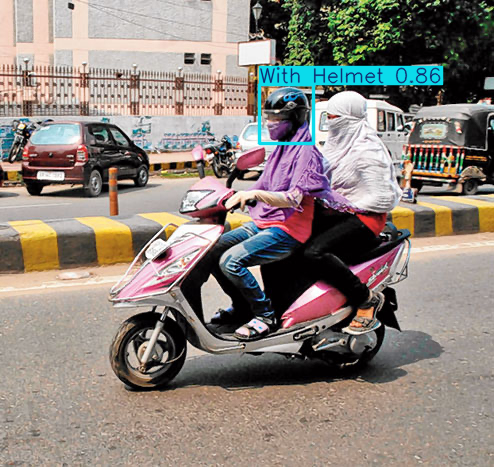

✅ Processed /kaggle/input/helmet-detection/images/BikesHelmets719.png

image 1/1 /kaggle/input/helmet-detection/images/BikesHelmets219.png: 448x640 4 With Helmets, 32.6ms
Speed: 1.6ms preprocess, 32.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


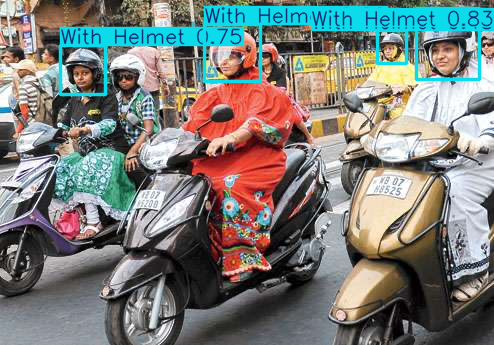

✅ Processed /kaggle/input/helmet-detection/images/BikesHelmets219.png

image 1/1 /kaggle/input/helmet-detection/images/BikesHelmets18.png: 384x640 1 With Helmet, 33.3ms
Speed: 1.3ms preprocess, 33.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


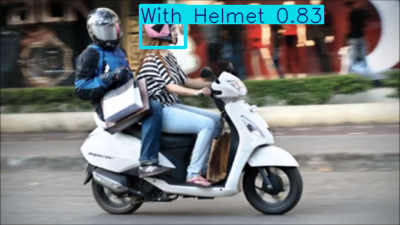

✅ Processed /kaggle/input/helmet-detection/images/BikesHelmets18.png


In [7]:
# ==========================
# 📌 Step 5: Run Inference on Test Images
# ==========================
test_images = glob.glob("/kaggle/input/helmet-detection/images/*.png")

for img_path in test_images[:3]:  # Limit to 3 images for quick testing
    results = model(img_path)
    for result in results:
        result.show()  # Display image
        result.save(filename=f"result_{os.path.basename(img_path)}")
    print(f"✅ Processed {img_path}")

In [8]:
# ==========================
# 📌 Step 6: Export Model to ONNX
# ==========================
if model.export(format="onnx"):
    print("✅ Model exported to ONNX format successfully!")

Ultralytics 8.3.78 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 196.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 242.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 157.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 11.5s, installed 2 packages: ['onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.48...
ONNX: export success ✅ 12.5s, saved as 'runs/detect/train/weights/best.onnx' (11.7 M